Name: Randi Prince, UID: u1431008, Class: CS6017, Date: 7/22/23

In [93]:
import pandas as pd

import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Step 1: Data Acquisition + Cleanup

In [120]:
df = pd.read_csv("fonts/COURIER.csv")
df

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,COURIER,scanned,42,0.4,0,0.0,0,0,14,11,...,1,1,1,1,1,1,1,1,1,1
1,COURIER,scanned,48,0.4,0,0.0,0,0,22,15,...,162,150,120,99,80,61,34,26,22,22
2,COURIER,scanned,51,0.4,0,0.0,0,0,22,16,...,184,184,166,139,116,83,64,45,30,23
3,COURIER,scanned,45,0.4,0,0.0,0,0,12,12,...,1,1,1,1,1,1,1,1,1,1
4,COURIER,scanned,78,0.4,0,0.0,0,0,13,12,...,1,1,1,1,1,255,255,255,86,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,COURIER,COURIER NEW,37,0.7,1,0.0,36,28,42,32,...,255,240,134,25,1,1,1,1,1,1
12225,COURIER,COURIER NEW,36,0.7,1,0.0,32,27,53,34,...,1,1,1,1,1,1,1,1,1,1
12226,COURIER,COURIER NEW,35,0.7,1,0.0,31,26,52,35,...,163,1,1,1,1,1,1,1,1,1
12227,COURIER,COURIER NEW,34,0.7,1,0.0,38,36,18,24,...,1,86,255,255,43,1,1,1,1,1


In [121]:
df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
numLabels = df['m_label'].value_counts()

# Get the labels that appear at least five times
labelsToUse = numLabels[numLabels > 4].index.tolist()

df = df[df['m_label'].isin(labelsToUse)]
df

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,42,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,48,1,9,14,15,45,87,134,186,226,...,162,150,120,99,80,61,34,26,22,22
2,51,1,3,21,46,67,128,178,213,234,...,184,184,166,139,116,83,64,45,30,23
3,45,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,78,255,255,255,255,255,255,171,1,1,...,1,1,1,1,1,255,255,255,86,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,37,1,1,1,1,1,1,25,134,240,...,255,240,134,25,1,1,1,1,1,1
12225,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12226,35,1,1,1,1,1,1,1,1,1,...,163,1,1,1,1,1,1,1,1,1
12227,34,43,255,255,255,255,255,255,255,86,...,1,86,255,255,43,1,1,1,1,1


In [122]:
# write a function that takes in one of these types of dataframe and returns 2 numpy arrays:

def getArrayData(df):
    # Xs which is a #samples x 20 x 20 array containing the pixel values
    # normalize the Xs array so the values go from 0-1 (most likely this requires dividing by 255)
    X = df.drop(columns='m_label').to_numpy(dtype=np.float32)
    X = np.array([x.reshape(20, 20) for x in X], dtype=np.float32) / 255
    print(max(df['m_label'].values))
    #  Ys which is a #samples x 1 array containing the ascii value for each character.
    Y = df['m_label'].to_numpy()
    
    return X, Y
X, Y = getArrayData(df)
print(len(Y))

126
1487


In [123]:
# dictionaries to convert from unicode number to label index and vice versa
def makeDictionaries(df):
    # create empty dictionaires 
    codeToIndex = {}
    indexToCode = {}
    col = df['m_label']
    j = 0
    for i in range(0, max(col.values) + 1):
        if i in col.values:
            codeToIndex[i] = j
            indexToCode[j] = i
            j = j + 1
    return (codeToIndex, indexToCode)

codeToIndex, indexToCode = makeDictionaries(df)
# display(codeToIndex)
# display(indexToCode)

In [124]:
# apply dictionary
for i in range( len(Y)):
    Y[i] = codeToIndex[Y[i]]
X = np.reshape(X, (-1, 1, 20, 20))

#make train and test datasets to use for cross validation
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=42, shuffle=True)
display(Y.size)
display(X.shape)

# make tensor datasets
trainData = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
testData = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
print(trainData[0][0].shape)
print(trainData[0][1].shape)
print(testData[0][0].shape)

1487

(1487, 1, 20, 20)

torch.Size([1, 20, 20])
torch.Size([])
torch.Size([1, 20, 20])


## Step 2: Build a PyTorch Network

In [125]:
# Compile and train your network like we did in class. You'll probably have to use the np.reshape() function on your data to make PyTorch happy.
# I reshaped my X values like np.reshape(Xs, (-1, 1, 20, 20)) to get them in the right format.

class Net(nn.Module):
    def __init__(self, output):
        super(Net, self).__init__()
        c1Out = 6
        c2Out = 16
        self.conv1 = nn.Conv2d( 1, c1Out, 3 )
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
        self.pooledOutputSize = c2Out * 3 * 3
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, output)
        
    def forward( self, x ):

        # Split into 2 lines above
        x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) 
#         print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
#         print(x.shape)
        
        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc2(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [126]:
print(X.shape)

(1487, 1, 20, 20)


In [127]:
def train( model, epochs, dataset ): # One epoch uses the entire training set (one batch at a time) - 60,000 images in this case
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    
    #this loads data and gets it in the right format for us
    trainloader = DataLoader( dataset, batch_size=8, shuffle=True, num_workers=0 )

    for epoch in range( epochs ): # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate( trainloader, 0 ):

            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels) 

            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights
            running_loss += loss.item()
            
            if i % 200 == 199: 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')


    

In [128]:
net = Net(len(df['m_label'].unique()))
train(net, 100, trainData)

Finished Training


## Step 3: Exploration and Evaluation

In [129]:
def evaluate( model, dataset ):  
    #load some test data
    testloader = torch.utils.data.DataLoader( dataset, batch_size=8,
                                              shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    with torch.no_grad(): # <- Since we are not training, the model does not need to calculate gradients
        for data in testloader:
            images, labels = data
            outputs = model( images )
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print( 'Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total) )

In [136]:
# Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?
evaluate(net, testData)

Accuracy of the network on the 10000 test images: 84 %


In [131]:
# Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer).
class AnotherNet(nn.Module):
    def __init__(self, output):
        super(AnotherNet, self).__init__()
        c1Out = 16
        c2Out = 64
#         c3Out = 64
        self.conv1 = nn.Conv2d( 1, c1Out, 3 )
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3)
#         self.conv3 = nn.Conv2d(c2Out, c3Out, 3)
        self.pooledOutputSize = c2Out * 3 * 3
        self.fc1 = nn.Linear(self.pooledOutputSize, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear( 200, output ) # 10 outputs at the end
        
    def forward( self, x ):

        # Split into 2 lines above
        x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x))) 
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
# Try to find a topology that works better than the one described above.

In [132]:

net2 = AnotherNet(len(df['m_label'].unique()))
train(net2, 100, trainData)

Finished Training


In [137]:
# Try to find a topology that works better than the one described above.
evaluate(net2, testData)
print("the above topology works 3% better than the initial net")

Accuracy of the network on the 10000 test images: 87 %
the above topology works 3% better than the initial net


In [169]:
# Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?
df2 = pd.read_csv("fonts/ARIAL.csv")
df2.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
numLabels = df2['m_label'].value_counts()
labelsToUse = numLabels[numLabels >= 4].index.tolist()

df2 = df2[df2['m_label'].isin(labelsToUse)]
df2

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,48,1,1,1,1,1,1,154,255,255,...,255,255,255,154,1,1,1,1,1,1
1,50,4,7,22,49,97,120,139,156,162,...,213,225,229,239,240,240,221,209,116,95
2,83,1,1,1,1,255,255,255,255,255,...,255,255,255,255,255,255,1,1,1,1
3,48,1,1,1,1,1,114,255,255,255,...,1,1,1,1,1,1,1,1,1,1
4,54,1,1,1,1,1,1,1,1,255,...,255,255,255,255,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26232,37,1,4,83,208,255,255,161,16,1,...,1,1,16,161,255,255,208,83,4,1
26233,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
26234,35,1,1,1,1,1,1,77,253,255,...,255,255,253,77,1,1,1,1,1,1
26235,34,43,255,255,255,255,255,255,255,255,...,43,255,255,255,255,213,1,1,1,1


In [170]:
X2, Y2 = getArrayData(df2)
codeToIndex, indexToCode = makeDictionaries(df2)

65532


In [171]:
# apply dictionary
for i in range( len(Y2)):
    Y2[i] = codeToIndex[Y2[i]]
X2 = np.reshape(X2, (-1, 1, 20, 20))

#make train and test datasets to use for cross validation
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,Y2, random_state=42, shuffle=True)
display(Y2.size)
display(X2.shape)

# make tensor datasets
trainData2 = TensorDataset(torch.from_numpy(X_train2), torch.from_numpy(y_train2))
testData2 = TensorDataset(torch.from_numpy(X_test2), torch.from_numpy(y_test2))
timesData = TensorDataset(torch.from_numpy(X2), torch.from_numpy(Y2))
print(trainData2[0][0].shape)
print(trainData2[0][1].shape)
print(testData2[0][0].shape)

24900

(24900, 1, 20, 20)

torch.Size([1, 20, 20])
torch.Size([])
torch.Size([1, 20, 20])


In [172]:
evaluate(net, timesData)

Accuracy of the network on the 10000 test images: 30 %


In [173]:
evaluate(net2, timesData)

Accuracy of the network on the 10000 test images: 30 %


In [174]:
print("when testing my two nets that were trained for font courier with font arial, both returned an accuracy of 30%")

when testing my two nets that were trained for font courier with font arial, both returned an accuracy of 30%


In [181]:
# Train your best network on inputs from the data from at least 2 different fonts.
df3 = pd.read_csv("fonts/TIMES.csv")
df3.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
numLabels = df3['m_label'].value_counts()
# print(np.median(numLabels))
labelsToUse = numLabels[numLabels > 4].index.tolist()

df3 = df3[df3['m_label'].isin(labelsToUse)]
df3

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,50,1,1,1,1,1,255,255,255,255,...,255,255,255,255,255,255,255,255,86,1
1,55,1,47,255,255,255,255,255,255,255,...,232,1,1,1,1,1,1,1,1,1
2,82,255,255,255,255,255,255,255,255,255,...,1,1,1,1,86,255,255,255,255,255
3,55,1,1,1,12,18,18,97,255,255,...,1,1,1,3,5,5,4,4,4,4
4,50,1,8,21,47,60,184,201,234,241,...,204,204,203,210,214,214,211,204,170,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12725,37,1,1,17,145,209,213,247,131,12,...,1,12,131,247,213,209,98,17,1,1
12726,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12727,35,1,1,1,1,1,1,4,126,255,...,255,255,126,4,1,1,1,1,1,1
12728,34,1,1,14,209,255,255,116,5,1,...,1,1,255,154,1,1,1,1,1,1


In [196]:
X3, Y3 = getArrayData(df3)
codeToIndex3, indexToCode3 = makeDictionaries(df3)

126


In [197]:
# apply dictionary
for i in range( len(Y3)):
    Y3[i] = codeToIndex3[Y3[i]]
X3 = np.reshape(X3, (-1, 1, 20, 20))

#make train and test datasets to use for cross validation
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,Y3, random_state=42, shuffle=True)
display(Y3.size)
display(X3.shape)

# make tensor datasets
trainData3 = TensorDataset(torch.from_numpy(X_train3), torch.from_numpy(y_train3))
testData3 = TensorDataset(torch.from_numpy(X_test3), torch.from_numpy(y_test3))
print(trainData3[0][0].shape)
print(trainData3[0][1].shape)
print(testData3[0][0].shape)

2082

(2082, 1, 20, 20)

torch.Size([1, 20, 20])
torch.Size([])
torch.Size([1, 20, 20])


In [198]:
net3 = AnotherNet(len(df3['m_label'].unique()))
train(net3, 100, trainData3)

Finished Training


In [199]:
evaluate(net3, testData3)

Accuracy of the network on the 10000 test images: 90 %


In [188]:
# Train your best network on inputs from the data from at least 2 different fonts.
df4 = pd.read_csv("fonts/CALIBRI.csv")
df4.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
numLabels = df4['m_label'].value_counts()
print(np.max(numLabels))
labelsToUse = numLabels[numLabels > 4].index.tolist()

df4 = df4[df4['m_label'].isin(labelsToUse)]
df4

8


,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,65059,1,1,1,1,1,1,1,1,1,...,255,255,255,86,1,1,1,1,1,1
1,65058,1,1,255,255,255,255,255,255,255,...,1,1,1,1,1,1,1,1,255,255
2,65057,255,255,255,255,255,132,1,1,1,...,1,1,1,1,1,1,1,1,97,255
3,65056,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,64260,1,1,1,42,217,255,255,188,38,...,145,255,45,1,1,1,1,1,189,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19063,37,1,1,1,1,13,29,29,29,6,...,1,6,60,142,142,132,24,1,1,1
19064,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
19065,35,1,1,1,1,1,1,1,1,255,...,255,255,77,1,1,1,1,1,1,1
19066,34,1,1,37,255,255,255,255,255,146,...,1,146,255,255,255,255,49,1,1,1


In [208]:
combinedDf = pd.concat([df3, df4])
combinedDf

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,16,1,1,1,1,1,255,255,255,255,...,255,255,255,255,255,255,255,255,86,1
1,21,1,47,255,255,255,255,255,255,255,...,232,1,1,1,1,1,1,1,1,1
2,48,255,255,255,255,255,255,255,255,255,...,1,1,1,1,86,255,255,255,255,255
3,21,1,1,1,12,18,18,97,255,255,...,1,1,1,3,5,5,4,4,4,4
4,16,1,8,21,47,60,184,201,234,241,...,204,204,203,210,214,214,211,204,170,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19063,37,1,1,1,1,13,29,29,29,6,...,1,6,60,142,142,132,24,1,1,1
19064,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
19065,35,1,1,1,1,1,1,1,1,255,...,255,255,77,1,1,1,1,1,1,1
19066,34,1,1,37,255,255,255,255,255,146,...,1,146,255,255,255,255,49,1,1,1


In [209]:
Xcombo, Ycombo = getArrayData(combinedDf)
codeToIndexCombo, indexToCodeCombo = makeDictionaries(combinedDf)

65059


In [210]:
# apply dictionary
for i in range( len(Ycombo)):
    Ycombo[i] = codeToIndexCombo[Ycombo[i]]
Xcombo = np.reshape(Xcombo, (-1, 1, 20, 20))

#make train and test datasets to use for cross validation
X_trainCombo, X_testCombo, y_trainCombo, y_testCombo = train_test_split(Xcombo,Ycombo, random_state=42, shuffle=True)
display(Ycombo.size)
display(Xcombo.shape)

# make tensor datasets
trainDataCombo = TensorDataset(torch.from_numpy(X_trainCombo), torch.from_numpy(y_trainCombo))
testDataCombo = TensorDataset(torch.from_numpy(X_testCombo), torch.from_numpy(y_testCombo))
print(trainDataCombo[0][0].shape)
print(trainDataCombo[0][1].shape)
print(testDataCombo[0][0].shape)

21150

(21150, 1, 20, 20)

torch.Size([1, 20, 20])
torch.Size([])
torch.Size([1, 20, 20])


In [211]:
netCombo = AnotherNet(len(combinedDf['m_label'].unique()))
train(netCombo, 100, trainDataCombo)

[1,   200] loss: 7.788
[1,   400] loss: 7.783
[1,   600] loss: 7.774
[1,   800] loss: 7.744
[1,  1000] loss: 7.669
[1,  1200] loss: 7.617
[1,  1400] loss: 7.521
[1,  1600] loss: 7.387
[1,  1800] loss: 7.275
[2,   200] loss: 6.764
[2,   400] loss: 6.537
[2,   600] loss: 6.473
[2,   800] loss: 6.257
[2,  1000] loss: 6.046
[2,  1200] loss: 5.862
[2,  1400] loss: 5.749
[2,  1600] loss: 5.554
[2,  1800] loss: 5.369
[3,   200] loss: 4.619
[3,   400] loss: 4.575
[3,   600] loss: 4.390
[3,   800] loss: 4.355
[3,  1000] loss: 4.158
[3,  1200] loss: 4.167
[3,  1400] loss: 4.027
[3,  1600] loss: 4.086
[3,  1800] loss: 3.985
[4,   200] loss: 3.538
[4,   400] loss: 3.464
[4,   600] loss: 3.449
[4,   800] loss: 3.386
[4,  1000] loss: 3.385
[4,  1200] loss: 3.374
[4,  1400] loss: 3.335
[4,  1600] loss: 3.278
[4,  1800] loss: 3.257
[5,   200] loss: 2.950
[5,   400] loss: 2.960
[5,   600] loss: 3.030
[5,   800] loss: 3.048
[5,  1000] loss: 2.898
[5,  1200] loss: 2.968
[5,  1400] loss: 2.890
[5,  1600] 

[39,   800] loss: 0.722
[39,  1000] loss: 0.760
[39,  1200] loss: 0.790
[39,  1400] loss: 0.781
[39,  1600] loss: 0.773
[39,  1800] loss: 0.776
[40,   200] loss: 0.656
[40,   400] loss: 0.686
[40,   600] loss: 0.705
[40,   800] loss: 0.723
[40,  1000] loss: 0.725
[40,  1200] loss: 0.734
[40,  1400] loss: 0.725
[40,  1600] loss: 0.806
[40,  1800] loss: 0.732
[41,   200] loss: 0.642
[41,   400] loss: 0.714
[41,   600] loss: 0.729
[41,   800] loss: 0.703
[41,  1000] loss: 0.725
[41,  1200] loss: 0.726
[41,  1400] loss: 0.694
[41,  1600] loss: 0.737
[41,  1800] loss: 0.747
[42,   200] loss: 0.636
[42,   400] loss: 0.650
[42,   600] loss: 0.679
[42,   800] loss: 0.676
[42,  1000] loss: 0.674
[42,  1200] loss: 0.716
[42,  1400] loss: 0.694
[42,  1600] loss: 0.758
[42,  1800] loss: 0.727
[43,   200] loss: 0.609
[43,   400] loss: 0.648
[43,   600] loss: 0.692
[43,   800] loss: 0.688
[43,  1000] loss: 0.698
[43,  1200] loss: 0.690
[43,  1400] loss: 0.658
[43,  1600] loss: 0.695
[43,  1800] loss

[77,   800] loss: 0.413
[77,  1000] loss: 0.439
[77,  1200] loss: 0.443
[77,  1400] loss: 0.466
[77,  1600] loss: 0.455
[77,  1800] loss: 0.472
[78,   200] loss: 0.401
[78,   400] loss: 0.383
[78,   600] loss: 0.409
[78,   800] loss: 0.409
[78,  1000] loss: 0.447
[78,  1200] loss: 0.484
[78,  1400] loss: 0.466
[78,  1600] loss: 0.410
[78,  1800] loss: 0.422
[79,   200] loss: 0.377
[79,   400] loss: 0.402
[79,   600] loss: 0.436
[79,   800] loss: 0.401
[79,  1000] loss: 0.434
[79,  1200] loss: 0.401
[79,  1400] loss: 0.446
[79,  1600] loss: 0.403
[79,  1800] loss: 0.480
[80,   200] loss: 0.376
[80,   400] loss: 0.439
[80,   600] loss: 0.374
[80,   800] loss: 0.433
[80,  1000] loss: 0.419
[80,  1200] loss: 0.448
[80,  1400] loss: 0.438
[80,  1600] loss: 0.439
[80,  1800] loss: 0.422
[81,   200] loss: 0.353
[81,   400] loss: 0.403
[81,   600] loss: 0.403
[81,   800] loss: 0.407
[81,  1000] loss: 0.417
[81,  1200] loss: 0.463
[81,  1400] loss: 0.420
[81,  1600] loss: 0.431
[81,  1800] loss

In [212]:
evaluate(netCombo, testDataCombo)

Accuracy of the network on the 10000 test images: 53 %


In [213]:
# Train your best network on inputs from the data from at least 2 different fonts
print("above i trained the model with just times font and then trained the model with times and calibri comboioned\n")
#How does your accuracy compare to the 1-font case?
print("my accuracy for the combined fonts was 53%, while with just one font I got an accuracy of 90%\n")


above i trained the model with just times font and then trained the model with times and calibri comboioned

my accuracy for the combined fonts was 53%, while with just one font I got an accuracy of 90%



In [203]:
#What accuracy do you see when testing with inputs from a font you didn't train on?
df5 = pd.read_csv("fonts/BLACKADDER.csv")
df5.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
df5

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,61442,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,61441,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,9674,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,8805,1,1,1,1,1,1,1,1,64,...,1,1,1,64,255,255,255,128,1,1
4,8804,1,1,1,1,1,1,1,1,1,...,255,255,128,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,37,1,1,1,1,1,1,1,1,1,...,59,1,1,1,1,1,1,1,1,1
948,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
949,35,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
950,34,1,1,1,1,1,1,1,1,209,...,255,255,186,1,1,1,1,1,1,1


In [204]:
X5, Y5 = getArrayData(df5)
codeToIndex5, indexToCode5 = makeDictionaries(df5)

61442


In [205]:
# apply dictionary
for i in range( len(Y5)):
    Y5[i] = codeToIndex5[Y5[i]]
X5 = np.reshape(X5, (-1, 1, 20, 20))

# make tensor datasets
Data5 = TensorDataset(torch.from_numpy(X5), torch.from_numpy(Y5))
print(Data5[0][0].shape)

torch.Size([1, 20, 20])


In [206]:
evaluate(netCombo, Data5)

Accuracy of the network on the 10000 test images: 5 %


In [207]:
#What accuracy do you see when testing with inputs from a font you didn't train on?
print("i see an accuracy of 5%...not great!")

i see an accuracy of 5%...not great!


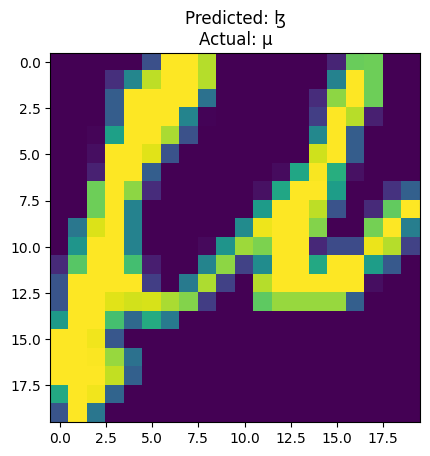

50.603 % sure it is correct


/Users/randiprince/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 854 (\N{COMBINING RIGHT ARROWHEAD AND UP ARROWHEAD BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


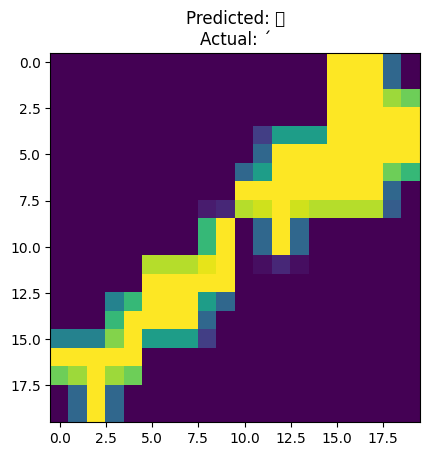

99.286 % sure it is correct


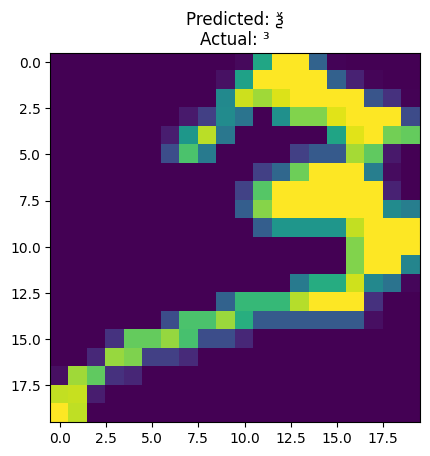

99.799 % sure it is correct


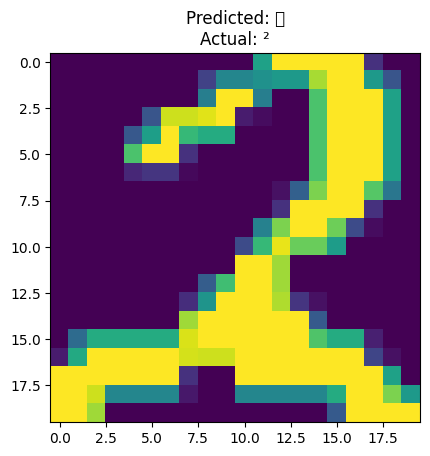

99.668 % sure it is correct


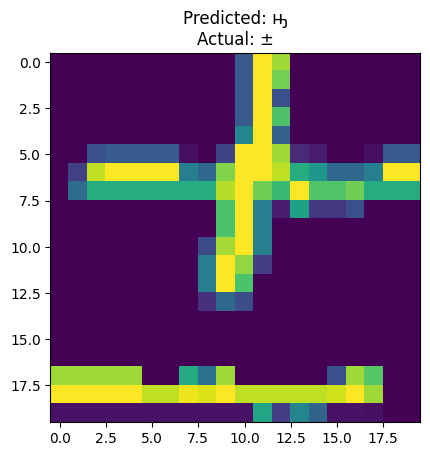

99.949 % sure it is correct


/Users/randiprince/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11799 (\N{DOUBLE OBLIQUE HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


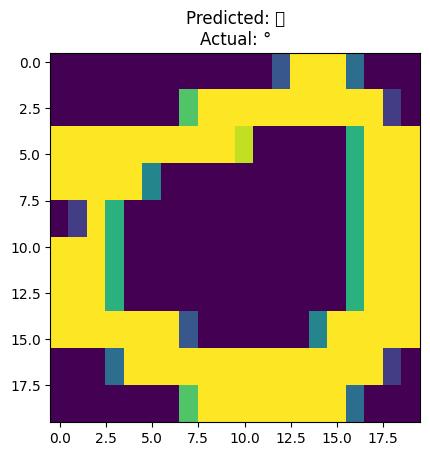

43.183 % sure it is correct


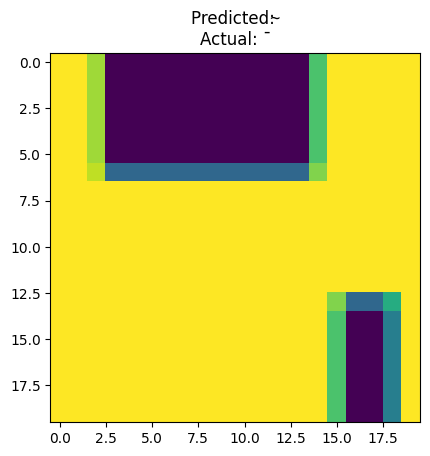

76.905 % sure it is correct


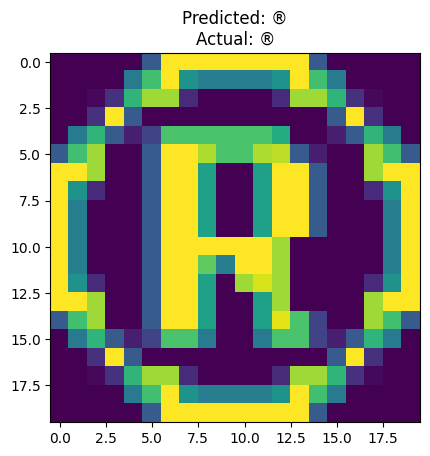

99.902 % sure it is correct


/Users/randiprince/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 874 (\N{COMBINING LATIN SMALL LETTER H}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


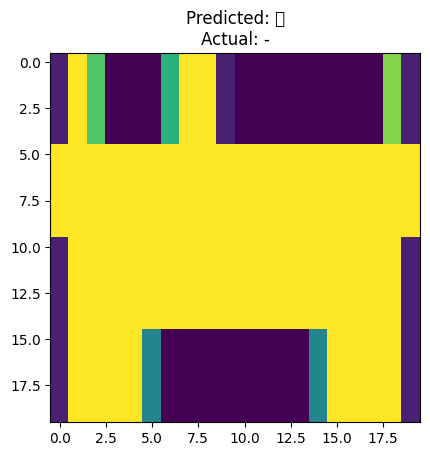

98.706 % sure it is correct


/Users/randiprince/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 43851 (\N{LATIN SMALL LETTER SCRIPT R}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


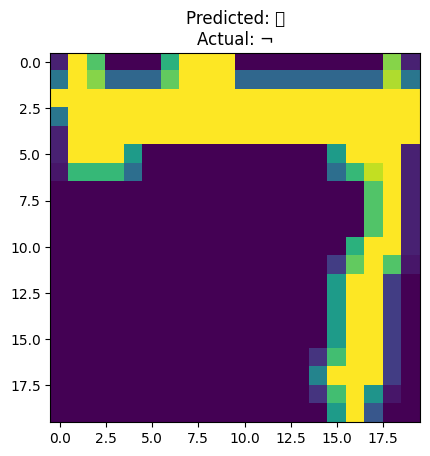

99.988 % sure it is correct


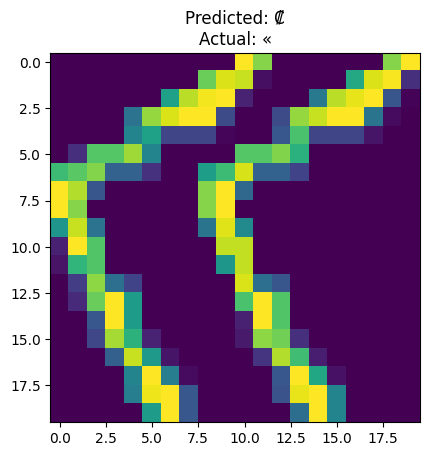

97.464 % sure it is correct


In [236]:
with torch.no_grad():
    for i in range(123, 134):
        outputs = netCombo.forward(torch.Tensor([X5[i]])) 
        _, predicted = torch.max(outputs.data, 1)
        plt.imshow(np.reshape(X5[i], (20, 20)))
        plt.title("Predicted: " + chr(indexToCodeCombo[predicted.item()]) + "\nActual: " + chr(indexToCode5[Y5[i]]))
        plt.show()
        val = torch.max(torch.softmax(outputs.squeeze(), dim=0)).item() * 100
        val = "%.3f" % val
        print(str(val)  + " % sure it is correct")

In [237]:
# Do you notice any patterns?
print("the most misclassified characters seems to be punctuation or characters that look a lot like the actual value like \n9 vs g or if the original charcter isn't super obvious or is unique, \n there's seems to be issues there as well")


the most misclassified characters seems to be punctuation or characters that look a lot like the actual value like 
9 vs g or if the original charcter isn't super obvious or is unique, 
 there's seems to be issues there as well


In [238]:
#The network only produces the relative probabilities that the input is any of the possible characters.
#Can you find examples where the network is unsure of the result?
print("the network seems to be mostr unsure of the result when the charcter is not a letter and more of a symbol")

the network seems to be mostr unsure of the result when the charcter is not a letter and more of a symbol


## Step 4: Denoising

In [252]:
# the inputs should be noisy images (original image + some guassian (normal) noise added)
# It might be easiest to make a new input array with the added noise.
nonNoisyX = X5
noisyX = X5

print(X5.shape)
for i in range(len(X5)):
    for j in range(20):
        for k in range(20):
            noise = np.random.normal(0, .05)
            noisyX[i, 0, j, k] = X5[i, 0, j, k] + noise
    

(952, 1, 20, 20)


In [253]:
trainNoisy, testNoisy, trainNotNoisy, testNotNoisy = train_test_split(noisyX, nonNoisyX, random_state=42, shuffle=True)


In [269]:
class CnnNet( nn.Module ):

    def __init__( self ):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32

        self.c1Out = 6 # filters from first conv layer
        self.c2Out = 6 # filters from 2nd conv layer
        
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x


In [286]:
criterion = nn.MSELoss()

def trainCNN( model, epochs, dataset ):

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam( model.parameters(), lr=1e-3 )

    batch_size = 8

    train_loader = torch.utils.data.DataLoader( dataset, batch_size=batch_size, shuffle=True, num_workers=0 )
    
    for epoch in range( epochs ):
        loss = 0

        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            batch_features = data[0]
        
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model( batch_features )
        
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion( outputs, batch_features )
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2500 == 2499:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, (i + 1)*batch_size, running_loss / 2000))
                running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len( train_loader )
    
        # display the epoch training loss
        print( "epoch: %d/%d, loss = %.8f" % (epoch + 1, epochs, loss) )


def evaluateCNN( model, dataset ):

    test_loader = torch.utils.data.DataLoader( dataset, batch_size=8, shuffle=True, num_workers=0 )
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            
            outputs = model( images )
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print( "Evaluation: Total loss: ", ( total_loss ) )

In [287]:
cnnNet = CnnNet()
DataNoisy = TensorDataset(torch.from_numpy(trainNoisy), torch.from_numpy(trainNotNoisy))
trainCNN(cnnNet, 100, DataNoisy)

epoch: 1/100, loss = 0.19282451
epoch: 2/100, loss = 0.14876652
epoch: 3/100, loss = 0.13074054
epoch: 4/100, loss = 0.11886493
epoch: 5/100, loss = 0.11087795
epoch: 6/100, loss = 0.10667143
epoch: 7/100, loss = 0.10198952
epoch: 8/100, loss = 0.09818587
epoch: 9/100, loss = 0.09587368
epoch: 10/100, loss = 0.09431333
epoch: 11/100, loss = 0.09213228
epoch: 12/100, loss = 0.09011607
epoch: 13/100, loss = 0.08773646
epoch: 14/100, loss = 0.08667708
epoch: 15/100, loss = 0.08528079
epoch: 16/100, loss = 0.08335773
epoch: 17/100, loss = 0.08232783
epoch: 18/100, loss = 0.08127785
epoch: 19/100, loss = 0.08008515
epoch: 20/100, loss = 0.07933659
epoch: 21/100, loss = 0.07804644
epoch: 22/100, loss = 0.07762637
epoch: 23/100, loss = 0.07727725
epoch: 24/100, loss = 0.07557459
epoch: 25/100, loss = 0.07495371
epoch: 26/100, loss = 0.07425244
epoch: 27/100, loss = 0.07376854
epoch: 28/100, loss = 0.07355298
epoch: 29/100, loss = 0.07226825
epoch: 30/100, loss = 0.07198887
epoch: 31/100, loss

In [288]:
DataNoisyTest = TensorDataset(torch.from_numpy(testNoisy), torch.from_numpy(testNotNoisy))
evaluateCNN(cnnNet, DataNoisyTest)

Evaluation: Total loss:  1.8472924456000328


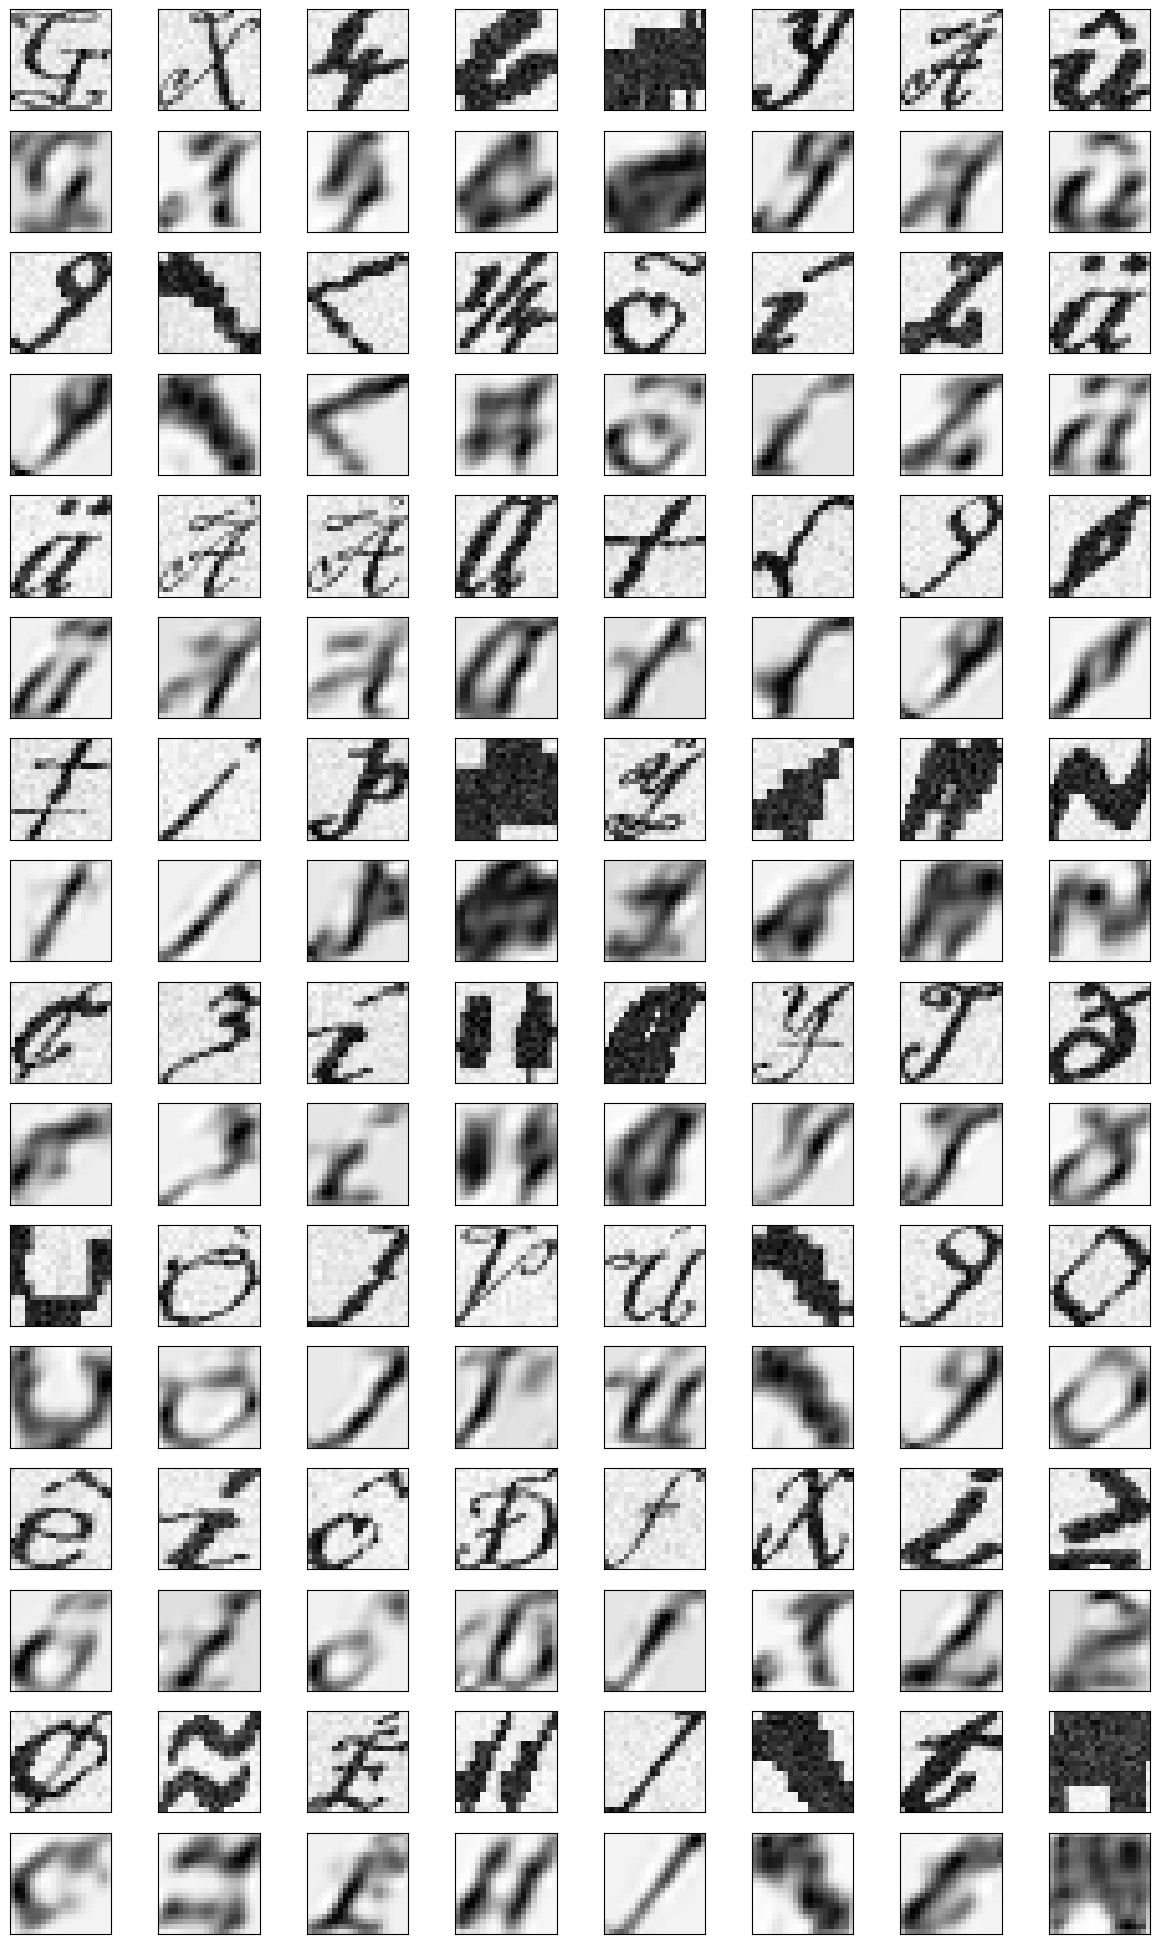

In [293]:
def drawComparisons( model, dataset):

    plt.figure( figsize=(15, 25) )

    test_loader = torch.utils.data.DataLoader( dataset, batch_size=8, shuffle=False, num_workers=0 )

    for i, batch in enumerate( test_loader ):
        if i >= 8:
            break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
                
            for j in range( len(images) ):
                # Display the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                # and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisons(cnnNet, DataNoisyTest)       

from the above, we can see that the auto encoder did remove some noise from the images i believe we will need a deeper/better encoder to get an even better result. the could be done by addding more dense layers or changing the encoder size to be smaller